In [16]:
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.tokenize import word_tokenize
from itertools import chain


In [219]:
nltk.download('punkt') #for tokenization

[nltk_data] Downloading package punkt to /home/haarrublar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [220]:
## loading the data without validation set (maybe in a second example)

# training and testing data
with open('X_train.txt') as train, open('X_test.txt') as test:
    X_train = train.read()
    X_test = test.read()

# training output
y_train = np.load('y_train.npy')

In [221]:
import re
import nltk


nltk.download('stopwords')

class DataCleaner:
    def __init__(self, stopwords=True):
        try:
            self.stop = nltk.corpus.stopwords.words('english')
            self.pattern = self.construct_pattern(stopwords)
        except Exception as e:
            print(f"Error initializing stopwords: {e}")
            self.stop = []
            self.pattern = ""

    def construct_pattern(self, stopwords=True):
        try:
            stopwords_pattern = r'\b(?:' + '\s*|'.join(map(re.escape, self.stop)) + r')\b' if stopwords else ''
            return stopwords_pattern + r'|[^\w\s]'
        except Exception as e:
            print(f"Error constructing pattern: {e}")
            return ""

    def clean_text(self, text):
        try:
            clean_data = [None]
            for _ in range(1):
                clean_data[0] = text.lower().split('\n')
                clean_data[0] = list(map(lambda x: re.sub(self.pattern, '', x), clean_data[0]))
            return clean_data[0]
        except AttributeError:
            print("Error: Input text is not a string.")
            return []
        except Exception as e:
            print(f"Error cleaning text: {e}")
            return []


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/haarrublar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [222]:
cleaner = DataCleaner()
train_text = cleaner.clean_text(X_train)
test_text = cleaner.clean_text(X_test)

In [223]:
type(test_text)

list

In [224]:
def _CreateTable(vocab, num_oov=1):
    init = tf.lookup.KeyValueTensorInitializer(
        vocab, tf.range(tf.size(vocab, out_type=tf.int64),
                        dtype=tf.int64),key_dtype=tf.string,
                        value_dtype=tf.int64)
    
    return tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)

In [225]:
tf_vocab = []

with open('vocab.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        tf_vocab.append(x)

In [226]:
# simple tokenization using nltk library
text_premodel_tokenization = list(map(word_tokenize, train_text))

# flatten the list using itertools
def flatten_chain(element):
    return list(chain.from_iterable(element))

text_premodel_tokenization = list(set(flatten_chain(text_premodel_tokenization))) ## avoiding repetition IMPORTANT

In [227]:
tf_vocab_table = _CreateTable(tf_vocab)
text_vocab = _CreateTable(text_premodel_tokenization)

In [228]:
def preprocess(data, labels):
    tokenizer = tf_text.WhitespaceTokenizer()
    data = tokenizer.tokenize(data)
    ids = tf.ragged.map_flat_values(text_vocab.lookup, data)
    return (ids, labels)

In [229]:
train_x = tf.constant(train_text)
train_y = tf.constant(y_train.flatten()) # the values must be flattened before entering to the model

# to check the dimension of the data
# for data, labels in train_dataset:
#     print("Data shape:", data.shape)
#     print("Labels shape:", labels.shape)

In [138]:
def preprocess(data, labels):
    subtokenizer = tf_text.WhitespaceTokenizer()
    tokenizer = tf_text.BertTokenizer(tf_vocab_table, token_out_type=tf.string)

    subtoken = subtokenizer.tokenize(data)
    data = tokenizer.tokenize(subtoken)

    data = data.merge_dims(-2,-1).merge_dims(-2,-1) # the dimension is (2,None,None,None) and it needs to be reduced for entering to the model
    ids = tf.ragged.map_flat_values(tf_vocab_table.lookup, data)
    return (ids, labels)

In [230]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(2)
train_dataset = train_dataset.map(preprocess)

# data_dataset = tf.data.Dataset.from_tensor_slices(train_x)
# label_dataset = tf.data.Dataset.from_tensor_slices(train_y)
# train_dataset = tf.data.Dataset.zip((data_dataset, label_dataset))
# train_dataset = train_dataset.batch(2)
# train_dataset = train_dataset.map(preprocess)

# to check the dimension of the data
# for data, labels in train_dataset:
#     print("Data shape:", data.shape)
#     print("Labels shape:", labels.shape)


In [233]:
train_text = np.array(train_text)
test_text = np.array(test_text)


model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(None,), dtype='int64', ragged=True),
  tf_text.keras.layers.ToDense(pad_value=0, mask=True),
  tf.keras.layers.Embedding(10000, 16),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
  optimizer="rmsprop",
  loss="binary_crossentropy",
  metrics=["accuracy"])

output = model.fit(train_dataset, epochs=1, batch_size=10, verbose=1)

2024-04-21 14:14:10.546570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 14:14:10.548421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 14:14:10.550154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

500/500 [==============================] - 30s 55ms/step - loss: 0.8180 - accuracy: 0.8250


## testing

In [175]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(None,), dtype='int64', ragged=True),
  tf_text.keras.layers.ToDense(pad_value=0, mask=True),
  tf.keras.layers.Embedding(10000, 16),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(32, activation='relu'),
  # tf.keras.layers.Dense(1) #use from_logits true when no activation output function
  tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #when activation function is not provided
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

output = model.fit(train_dataset, epochs=10, batch_size=10, verbose=1)

2024-04-21 11:59:20.538171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 11:59:20.540063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 11:59:20.541500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-04-21 11:59:21.597783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 11:59:21.602523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 11:59:21.605773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

500/500 [==============================] - 49s 88ms/step - loss: 0.8411 - accuracy: 0.5040
Epoch 2/10
500/500 [==============================] - 41s 81ms/step - loss: 0.6843 - accuracy: 0.6290
Epoch 3/10
500/500 [==============================] - 40s 80ms/step - loss: 0.6830 - accuracy: 0.5890
Epoch 4/10
500/500 [==============================] - 40s 79ms/step - loss: 0.6629 - accuracy: 0.6410
Epoch 5/10
500/500 [==============================] - 43s 86ms/step - loss: 0.6090 - accuracy: 0.7090
Epoch 6/10
500/500 [==============================] - 44s 89ms/step - loss: 0.4930 - accuracy: 0.8000
Epoch 7/10
500/500 [==============================] - 41s 83ms/step - loss: 0.3707 - accuracy: 0.8780
Epoch 8/10
500/500 [==============================] - 42s 83ms/step - loss: 0.2557 - accuracy: 0.9300
Epoch 9/10
500/500 [==============================] - 42s 84ms/step - loss: 0.1731 - accuracy: 0.9470
Epoch 10/10
500/500 [==============================] - 42s 83ms/step - loss: 0.1276 - accurac

In [272]:
test_x1 = tf.constant(np.array(['best localcoop game ever played']))
test_x2 = tf.constant(test_text)


def preprocess_test(data):
    t = tf_text.WhitespaceTokenizer()
    data = t.tokenize(data)
    ids = tf.ragged.map_flat_values(text_vocab.lookup, data)
    return ids

test_dataset = tf.data.Dataset.from_tensor_slices(test_x1)
test_dataset = test_dataset.batch(2, drop_remainder=True)
test_dataset = test_dataset.map(preprocess_test)

In [275]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 to_dense_3 (ToDense)        (None, None)              0         
                                                                 
 embedding_17 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_17 (LSTM)              (None, 32)                6272      
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
_________________________________________________________________


In [274]:
tf.config.run_functions_eagerly(True)

modeling_test = model.predict(test_dataset)


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [241]:
modeling_test

array([[2.12729337e-05],
       [2.04881217e-05],
       [2.10179060e-05],
       [2.13706153e-05],
       [3.93521087e-03],
       [5.40431589e-03],
       [1.99938750e-05],
       [2.09410755e-05],
       [1.40995637e-03],
       [6.76609401e-04],
       [2.13341045e-05],
       [2.10643157e-05],
       [2.10009348e-05],
       [2.08906313e-05],
       [2.04666004e-01],
       [2.62191206e-01],
       [8.52138677e-04],
       [7.44008226e-03],
       [2.85255846e-05],
       [4.02347214e-05],
       [2.08915881e-05],
       [1.99910919e-05],
       [2.12836458e-05],
       [2.04163262e-05],
       [2.08938600e-05],
       [2.01221683e-05],
       [2.32330513e-05],
       [2.20621241e-05],
       [2.02300162e-05],
       [2.08915881e-05],
       [2.08995589e-05],
       [2.00978884e-05],
       [2.26435277e-05],
       [2.33169085e-05],
       [2.04914049e-05],
       [2.08905112e-05],
       [2.87469484e-05],
       [2.75484836e-05],
       [2.08917481e-05],
       [1.97533136e-05],


In [31]:
# output.history.keys()
print(output.history)

{'loss': [0.6944022178649902, 0.6852022409439087, 0.6165174841880798, 0.5233860015869141, 0.4619556963443756, 0.42073410749435425, 0.37075966596603394, 0.3233596682548523, 0.3246699869632721, 0.2923782467842102, 0.29290029406547546, 0.3097165822982788, 0.2723950743675232, 0.262967586517334, 0.261783629655838, 0.25755542516708374, 0.23738890886306763, 0.2263578474521637, 0.2405797243118286, 0.24024330079555511], 'accuracy': [0.5104477405548096, 0.5716418027877808, 0.6970149278640747, 0.7597014904022217, 0.8059701323509216, 0.8388059735298157, 0.8537313342094421, 0.8671641945838928, 0.8686566948890686, 0.8820895552635193, 0.8910447955131531, 0.888059675693512, 0.8970149159431458, 0.9074627161026001, 0.8985074758529663, 0.904477596282959, 0.9179104566574097, 0.9134328365325928, 0.9089552164077759, 0.9104477763175964], 'val_loss': [0.6939731240272522, 0.6889931559562683, 0.7163700461387634, 0.7700631618499756, 0.6361534595489502, 0.6406651139259338, 0.6579846143722534, 0.7890434265136719, 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


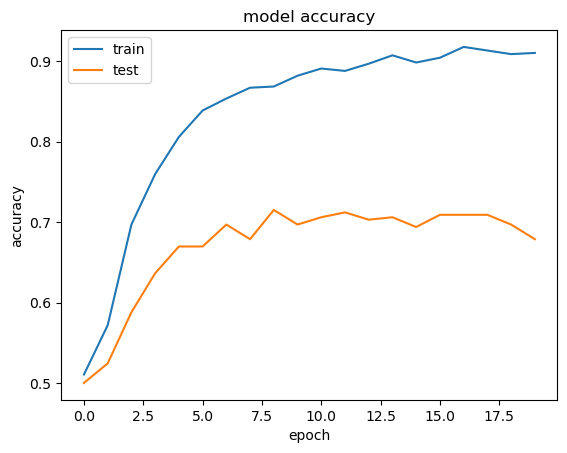

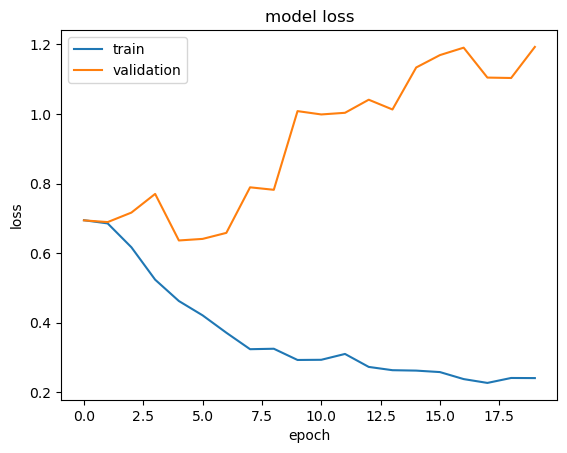

In [28]:
import matplotlib.pyplot as plt

# Extract the loss and accuracy values from the output

print(output.history.keys())
# summarize history for accuracy
plt.plot(output.history['accuracy'])
plt.plot(output.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Apparenlty there is overfitting, let's add some regularizations over the layers.

After some regulation and serach about the model structure in general, the conclusion is that the size of the validation and training data make the model overfit.

In [61]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(None,), dtype='int64', ragged=True),
  tf_text.keras.layers.ToDense(pad_value=0, mask=True),
  tf.keras.layers.Embedding(10000, 16),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(32, activation='relu'),
  # tf.keras.layers.Dense(1) #use from_logits true when no activation output function
  tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #when activation function is not provided
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

output = model.fit(train_dataset, epochs=20, batch_size=10, verbose=1)

2024-04-21 09:03:38.388446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 09:03:38.389700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 09:03:38.391036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-04-21 09:03:39.357263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 09:03:39.360189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 09:03:39.362109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

335/335 [==============================] - 34s 92ms/step - loss: 0.6931 - accuracy: 0.4910
Epoch 2/20
335/335 [==============================] - 33s 99ms/step - loss: 0.6911 - accuracy: 0.5627
Epoch 3/20
335/335 [==============================] - 35s 104ms/step - loss: 0.6856 - accuracy: 0.6522
Epoch 4/20
335/335 [==============================] - 34s 101ms/step - loss: 0.6572 - accuracy: 0.7328
Epoch 5/20
335/335 [==============================] - 34s 102ms/step - loss: 0.5384 - accuracy: 0.8045
Epoch 6/20
335/335 [==============================] - 33s 99ms/step - loss: 0.3693 - accuracy: 0.8776
Epoch 7/20
335/335 [==============================] - 33s 98ms/step - loss: 0.2708 - accuracy: 0.9284
Epoch 8/20
335/335 [==============================] - 34s 100ms/step - loss: 0.1964 - accuracy: 0.9537
Epoch 9/20
335/335 [==============================] - 34s 101ms/step - loss: 0.1509 - accuracy: 0.9627
Epoch 10/20
335/335 [==============================] - 32s 97ms/step - loss: 0.1245 - ac

In [277]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
num_words=10000)

17464789/17464789 [==============================] - 2s 0us/step


In [278]:
train_data

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

## new approach

In [22]:
import tensorflow_datasets as tfds
dataset2, info2 = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

In [26]:
train_dataset2, test_dataset2 = dataset['train'], dataset['test']

In [174]:
for element in train_dataset2.take(1):
    print(element)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


2024-04-21 13:57:05.305547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-21 13:57:05.306237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-21 13:57:05.356584: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

In [169]:
train_dataset2

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [195]:
y_train_list = y_train.tolist()

# flatten the list using itertools
def flatten_chain(element):
    return list(chain.from_iterable(element))

y_train_list = flatten_chain(y_train_list)

In [218]:
import tensorflow as tf

# Define the tensor values
text_tensor = tf.constant(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.")
label_tensor = tf.constant(0, dtype=tf.int64)

# Create the dataset from tensor slices
dataset = tf.data.Dataset.from_tensor_slices((text_tensor, label_tensor))

# Prefetch the dataset
prefetch_dataset = dataset.prefetch(1)

# Print the first element of the prefetch dataset
print(prefetch_dataset.element_spec)
print(next(iter(prefetch_dataset)))

ValueError: Unbatching a tensor is only supported for rank >= 1

In [193]:
# type(train_dataset)
for element in dataset.take(1):
    print(element)

(<tf.Tensor: shape=(), dtype=string, numpy=b'came witches stayed gwent'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


2024-04-21 14:01:00.151472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1000]
	 [[{{node Placeholder/_1}}]]


In [164]:
train_x = tf.constant(train_text)
train_y = tf.constant(y_train.flatten())

def preprocess(text, labels):
    tokenizer = tf_text.WhitespaceTokenizer()
    text = tokenizer.tokenize(text)
    text = tf.strings.reduce_join(text.to_tensor(), separator=' ')
    ids = tf.ragged.map_flat_values(text_vocab.lookup, text)
    return (ids, labels)


BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(BATCH_SIZE)
train_dataset = train_dataset.map(preprocess)
# train_dataset = train_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)

In [165]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [166]:
# type(train_dataset)
for element in train_dataset.take(1):
    print(element)

(<tf.Tensor: shape=(), dtype=int64, numpy=6022>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>)


2024-04-21 13:50:49.976378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


In [202]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(dataset.map(lambda text, label: text))

2024-04-21 14:02:16.410313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1000]
	 [[{{node Placeholder/_1}}]]


In [203]:
import tensorflow_text as tf_text

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
  optimizer="rmsprop",
  loss="binary_crossentropy",
  metrics=["accuracy"])

In [204]:
history = model.fit(dataset, epochs=10, verbose=1)

Epoch 1/10


ValueError: in user code:

    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_14' (type Sequential).
    
    Input 0 of layer "bidirectional_14" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)
    
    Call arguments received by layer 'sequential_14' (type Sequential):
      • inputs=tf.Tensor(shape=(), dtype=string)
      • training=True
      • mask=None


In [54]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

ValueError: in user code:

    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/data/miniconda3/envs/sentimentA/lib/python3.11/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "bidirectional_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None
